# Tutorial Session 2

Note: This is the **instructor copy**, for the tutorial use the **participant copy** (which is based on this copy with most of the code removed).

## Package imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [2]:
import MDAnalysis as mda
import MDAnalysisData as data
print(mda.__version__)
print(data.__version__)

0.19.0
0.3.0+5.g39325a3.dirty


## AdK test trajectories
Look again at AdK trajectories...

In [9]:
adk_eq = data.datasets.fetch_adk_equilibrium()
adk_dims = data.datasets.fetch_adk_transitions_DIMS()

In [6]:
adk_dims.keys()

dict_keys(['topology', 'trajectories', 'N_trajectories', 'DESCR'])

In [11]:
u = mda.Universe(adk_dims['topology'], adk_dims['trajectories'])
print(u)

<Universe with 3341 atoms>


In [12]:
eq = mda.Universe(adk_eq['topology'], adk_eq['trajectory'])
print(eq)

<Universe with 3341 atoms>


## Trajectories

The `Universe.trajectory` object is the entry point to all trajectory functionality:

In [13]:
u.trajectory

<ChainReader ['dims0138_fit-core.dcd', 'dims0192_fit-core.dcd', 'dims0048_fit-core.dcd', 'dims0195_fit-core.dcd', 'dims0180_fit-core.dcd', 'dims0008_fit-core.dcd', 'dims0178_fit-core.dcd', 'dims0187_fit-core.dcd', 'dims0039_fit-core.dcd', 'dims0093_fit-core.dcd', 'dims0149_fit-core.dcd', 'dims0094_fit-core.dcd', 'dims0081_fit-core.dcd', 'dims0109_fit-core.dcd', 'dims0079_fit-core.dcd', 'dims0086_fit-core.dcd', 'dims0186_fit-core.dcd', 'dims0179_fit-core.dcd', 'dims0009_fit-core.dcd', 'dims0181_fit-core.dcd', 'dims0194_fit-core.dcd', 'dims0049_fit-core.dcd', 'dims0193_fit-core.dcd', 'dims0139_fit-core.dcd', 'dims0087_fit-core.dcd', 'dims0078_fit-core.dcd', 'dims0108_fit-core.dcd', 'dims0080_fit-core.dcd', 'dims0095_fit-core.dcd', 'dims0148_fit-core.dcd', 'dims0092_fit-core.dcd', 'dims0038_fit-core.dcd', 'dims0110_fit-core.dcd', 'dims0145_fit-core.dcd', 'dims0032_fit-core.dcd', 'dims0067_fit-core.dcd', 'dims0098_fit-core.dcd', 'dims0117_fit-core.dcd', 'dims0142_fit-core.dcd', 'dims0035_f

Trajectories have a length in frames and in **ps** (the base MDAnalysis time unit):

In [48]:
u.trajectory.n_frames

19691

In [49]:
len(u.trajectory)

19691

In [16]:
u.trajectory.totaltime

962608.7975240413

### `Timestep` 

They also contain a `Timestep` object, which holds the **current**
* frame and time
* unitcell dimensions (if available) as `[A, B, C, alpha, beta, gamma]`
* raw positions (and velocities and forces, if available)
* additional data, if defined by the trajectory format

In [17]:
ts = u.trajectory.ts
ts

< Timestep 0 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [18]:
ts.frame

0

In [19]:
ts.time

0.0

In [20]:
ts.dimensions

array([ 0.,  0.,  0., 90., 90., 90.], dtype=float32)

In [21]:
eq.trajectory.ts.dimensions

array([85.53471, 85.53471, 85.53471, 90.     , 90.     , 90.     ],
      dtype=float32)

In [22]:
ts.positions

array([[ 2.4326358,  9.5135565, 11.561407 ],
       [ 2.666365 ,  8.647143 , 12.120124 ],
       [ 1.7232528, 10.07545  , 12.071542 ],
       ...,
       [-8.741671 , 12.245849 ,  9.721865 ],
       [-8.8482275, 13.458019 ,  9.9984   ],
       [-9.001447 , 11.810852 ,  8.609451 ]], dtype=float32)

How many coordinates?

In [23]:
ts.positions.shape

(3341, 3)

In [24]:
ts.velocities

NoDataError: This Timestep has no velocities

In [25]:
ts.forces

NoDataError: This Timestep has no forces

What is the time between frames?

In [26]:
ts.dt

48.888207086035614

### Moving forward... or anywhere
`Universe.trajectory` behaves a bit like a list of Timesteps:
* index --> `Timestep`: go to frame
* iterate --> `Timestep`: go to each frame in sequence
* slice --> new trajectory iterator

#### Trajectory indexing

Trajectory indexing and slicing uses **0-based indices** (as in standard Python) and MDAnalysis also numbers frames starting with 0. Thus the "tenth frame" in a trajectory has ``ts.frame == 9``.

Let's move to an arbitrary frame in the trajectory:

In [31]:
u.trajectory[42]

< Timestep 42 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [32]:
u.trajectory.ts.frame

42

In [34]:
ts.frame

0

In [37]:
u.trajectory[-23]

< Timestep 19668 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [38]:
u.trajectory.ts

< Timestep 19668 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

Note that you *cannot* "remember" a `Timestep`: The following will *not keep a copy of the timeset at frame 20*:

In [39]:
ts20 = u.trajectory[20]

In [40]:
ts20.frame

20

In [41]:
u.trajectory[42]

< Timestep 42 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [42]:
ts20

< Timestep 20 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

If you *really* want to, you can make a copy (but this is not used very much):

In [43]:
ts42copy = u.trajectory.ts.copy()

In [44]:
ts42copy.frame

42

In [45]:
u.trajectory[2]

< Timestep 2 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [46]:
ts42copy.frame

42

#### Iteration and Slicing
The **most common usage pattern** in MDAnalysis: Access each frame in a trajectory:

In [47]:
results = []
for ts in u.trajectory:
    results.append(ts.frame)
results = np.array(results)
results

array([    0,     1,     2, ..., 19688, 19689, 19690])

... or arbitrary slices:

In [50]:
results = np.fromiter((ts.frame for ts in u.trajectory[10::20]), dtype=np.int64)
results

array([   10,    30,    50,    70,    90,   110,   130,   150,   170,
         190,   210,   230,   250,   270,   290,   310,   330,   350,
         370,   390,   410,   430,   450,   470,   490,   510,   530,
         550,   570,   590,   610,   630,   650,   670,   690,   710,
         730,   750,   770,   790,   810,   830,   850,   870,   890,
         910,   930,   950,   970,   990,  1010,  1030,  1050,  1070,
        1090,  1110,  1130,  1150,  1170,  1190,  1210,  1230,  1250,
        1270,  1290,  1310,  1330,  1350,  1370,  1390,  1410,  1430,
        1450,  1470,  1490,  1510,  1530,  1550,  1570,  1590,  1610,
        1630,  1650,  1670,  1690,  1710,  1730,  1750,  1770,  1790,
        1810,  1830,  1850,  1870,  1890,  1910,  1930,  1950,  1970,
        1990,  2010,  2030,  2050,  2070,  2090,  2110,  2130,  2150,
        2170,  2190,  2210,  2230,  2250,  2270,  2290,  2310,  2330,
        2350,  2370,  2390,  2410,  2430,  2450,  2470,  2490,  2510,
        2530,  2550,

... and for numpy afficionados, "fancy indexing" also works:

In [51]:
results = np.fromiter((ts.frame for ts in u.trajectory[[10, 20, 10, 0]]), dtype=np.int64)
results

array([10, 20, 10,  0])

*Note*: It does not make sense to create a list of timesteps like
```python
timesteps = [ts for ts in u.trajectory]
```
or
```python
timesteps = list(u.trajectory)
```
because each list item will refer to the same currently active timestep (the first one because at the end of iteration the trajectory rewinds).

#### Challenge: Reverse the trajectory 

Produce an array from `ts.frame` that is reversed, ie `[101, 100, ..., 1, 0]`

In [52]:
results = np.array([ts.frame for ts in reversed(u.trajectory)])
results

array([19690, 19689, 19688, ...,     2,     1,     0])

In [53]:
np.array([ts.frame for ts in u.trajectory[::-1]])

array([19690, 19689, 19688, ...,     2,     1,     0])

Note: slicing and indexing works for all trajectory formats!

## Analyzing trajectories with `Atomgroup`s
Using the raw `Timestep` positions is cumbersome. Moving the time step automatically updates all positions that `Atomgroup.positions` sees at this instance:

In [54]:
u.trajectory[0]

< Timestep 0 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [55]:
protein = u.select_atoms("protein")
protein

<AtomGroup with 3341 atoms>

Calculate the radius of gyration
\begin{equation*}
    R_{\text{gyr}} = \sqrt{\frac{1}{M}\sum_{i=1}^{N}m_{i}(\textbf{r}_{i} - \textbf{R})^{2}}
\end{equation*}
 with `AtomGroup.radius_of_gyration()`:

In [56]:
protein.radius_of_gyration()

16.652347539723213

What's the current frame?

In [57]:
u.trajectory.ts.frame

0

Move to the last one:

In [58]:
u.trajectory[-1]

< Timestep 19690 with unit cell dimensions [ 0.  0.  0. 90. 90. 90.] >

In [59]:
protein.radius_of_gyration()

19.549907672246068

Remember: **All coordinate-dependent properties of an `AtomGroup` change when the trajectory index is changed.** Think of a pointer moving along the trajectory file. `AtomGroup` fetches coordinates from the frame that the pointer points to.

#### Example: radius of gyration time series
Collect `(time, radius_of_gyration)` for the protein for frames and plot $R_{\mathrm{gyr}}(t)$, with time in ps.

In [77]:
protein = u.select_atoms("protein")
results = []
for ts in u.trajectory[:97]:
    results.append((ts.time, protein.radius_of_gyration()))
time, rgyr = np.transpose(results)

Text(0, 0.5, '$R_{\\mathrm{gyr}}$ ($\\AA$)')

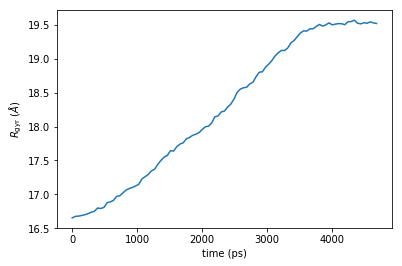

In [78]:
ax = plt.subplot(111)
ax.plot(time, rgyr)
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"$R_{\mathrm{gyr}}$ ($\AA$)")

#### Challenge: Plot $R_\mathrm{gyr}$ for equilibrium MD simulation 

In [79]:
peq = eq.select_atoms("protein")
eqrgyr = np.array([(ts.time, peq.radius_of_gyration()) for ts in eq.trajectory]).transpose()

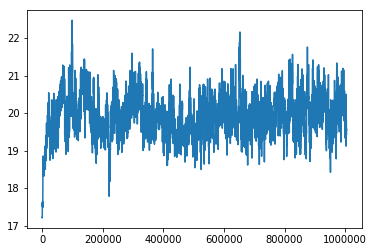

In [80]:
plt.plot(eqrgyr[0], eqrgyr[1])

#### CHALLENGE: Collective variable analysis of AdK

1. Generate timeseries for domain angles, i.e. $t$, $\theta_\mathrm{NMP}(t)$, $\theta_\mathrm{LID}(t)$, using the previously defined functions `theta_NMP()` and `theta_LID()`.
2. Plot (a) the time series, (b) the angles against each other.
3. Bonus: 
   - is the radius of gyration correlated with the angles?
   - for one of the equilibrium trajectories?

In [81]:
import numpy as np
from numpy.linalg import norm

def theta_NMP(ag):
    """Calculate the NMP-CORE angle for E. coli AdK in degrees"""
    C = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 90:100 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 35:55 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

def theta_LID(ag):
    """Calculate the LID-CORE angle for E. coli AdK in degrees"""
    C = ag.select_atoms("resid 179:185 and backbone").center_of_geometry()
    B = ag.select_atoms("resid 115:125 and backbone").center_of_geometry()
    A = ag.select_atoms("resid 125:153 and backbone").center_of_geometry()
    BA = A - B
    BC = C - B
    theta = np.arccos(np.dot(BA, BC)/(norm(BA)*norm(BC)))
    return np.rad2deg(theta)

In [82]:
data = np.array([[ts.time, theta_NMP(u), theta_LID(u)] for ts in u.trajectory[:97]])

In [83]:
data[:3]

array([[  0.        ,  43.15551665, 105.52097184],
       [ 48.88820709,  44.16048346, 107.49152398],
       [ 97.77641417,  44.29206964, 108.53776272]])

In [84]:
time, aNMP, aLID = data.transpose()

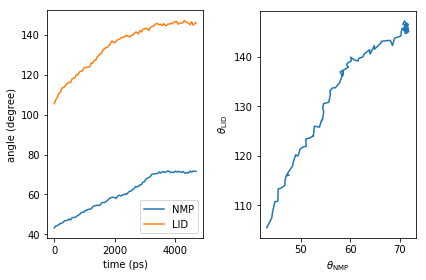

In [85]:
ax1 = plt.subplot(121)
ax1.plot(time, aNMP, label="NMP")
ax1.plot(time, aLID, label="LID")
ax1.set_xlabel("time (ps)")
ax1.set_ylabel("angle (degree)")
ax1.legend(loc="best")
ax2 = plt.subplot(122)
ax2.plot(aNMP, aLID)
ax2.set_xlabel(r"$\theta_\mathrm{NMP}$")
ax2.set_ylabel(r"$\theta_\mathrm{LID}$")
ax2.set_aspect(1)
plt.tight_layout()

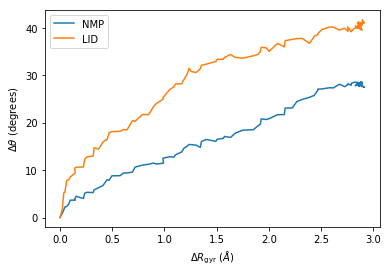

In [86]:
ax = plt.subplot(111)
ax.plot(rgyr-rgyr[0], aNMP-aNMP[0], label="NMP")
ax.plot(rgyr-rgyr[0], aLID-aLID[0], label="LID")
ax.set_xlabel(r"$\Delta R_\mathrm{gyr}$ ($\AA$)")
ax.set_ylabel(r"$\Delta\theta$ (degrees)")
ax.legend(loc="best")


Bonus: note, only use first 200 frames of the equilibrium trajectory.

In [87]:
eqdata = np.array([[ts.time, theta_NMP(eq), theta_LID(eq)] for ts in eq.trajectory[:200]]).transpose()

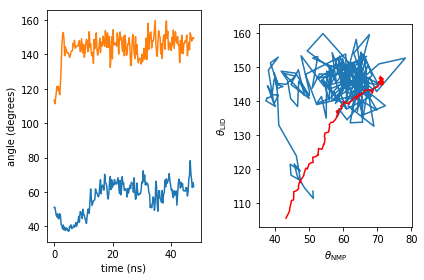

In [88]:
ax1 = plt.subplot(121)
ax1.plot(eqdata[0]/1000, eqdata[1], label="NMP")
ax1.plot(eqdata[0]/1000, eqdata[2], label="LID")
ax1.set_xlabel("time (ns)")
ax1.set_ylabel("angle (degrees)")
ax2 = plt.subplot(122)
ax2.plot(eqdata[1], eqdata[2])
ax2.plot(aNMP, aLID, color="red")
ax2.set_xlabel(r"$\theta_\mathrm{NMP}$")
ax2.set_ylabel(r"$\theta_\mathrm{LID}$")
ax2.set_aspect(1)
plt.tight_layout()

### Digression: using frame indices to filter a trajectory

If you have a quantity that is ceap to compute, you can use it to filter a trajectory:

In [89]:
peq = eq.select_atoms("protein")
closed = [ts.frame for ts in eq.trajectory[:100] if peq.radius_of_gyration() < 19]

In [90]:
u.trajectory[closed]

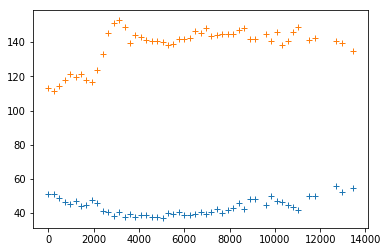

In [91]:
plt.plot(eqdata[0, closed], eqdata[1, closed], '+')
plt.plot(eqdata[0, closed], eqdata[2, closed], '+')

## Trajectory manipulation

One can easily modify the coordinates of the current timestep: Either directly in `Timestep.positions` or via `AtomGroup` methods such as `translate` or `rotate`.

In particular, we can optimally superimpose RMSD fitting.


In [92]:
import MDAnalysis.analysis.rms as rms

We want to calculate the RMSD for an optimal superposition of the C-alpha atoms. As a reference, we take the coordinates of the initial frame of the trajectory:

In [93]:
ca = u.select_atoms("name CA")

u.trajectory[0]
ref = ca.positions.copy()
ref_com = ca.center_of_mass()

Remove translations by moving to the center of mass of the reference:

In [94]:
u.trajectory[-1]
ca.translate(-ca.center_of_mass() + ref_com)

<AtomGroup with 214 atoms>

Then calculate the RMSD after optimum RMSD superposition with `rmsd()`:

In [95]:
rms.rmsd(ca.positions, ref)

7.347633833633634

Actually, `rmsd()` has the *center* keyword that does a superposition for us:

In [96]:
u.trajectory[20]
rms.rmsd(ca.positions, ref, center=True)

2.5637372031369803

In [97]:
u.trajectory[-2]
rms.rmsd(ca.positions, ref, center=True)

7.335508702256255

You can manually superimpose using translation and the optimal rotation matrix (from `rms.rotation_matrix()`) but for many use cases see the contents of the [MDAnalysis.analysis.align](http://pythonhosted.org/MDAnalysis/documentation_pages/analysis/align.html) module.

In [98]:
# maybe??? alignto()

#### Challenge: RMSD time series
Calculate $\mathrm{RMSD}(t)$ (relative to the initial frame) and plot it.

* use the "manual" approach (instead of `MDAnalysis.rms.RMSD` ;-)
* Bonus: compare the DIMS trajectories to the equilibrium trajectories (hint: plot as fraction of total time)

In [102]:
data = np.array([[ts.time, rms.rmsd(ca.positions, ref, center=True)] 
                 for ts in u.trajectory[:97]]).transpose()

In [103]:
data.shape

(2, 97)

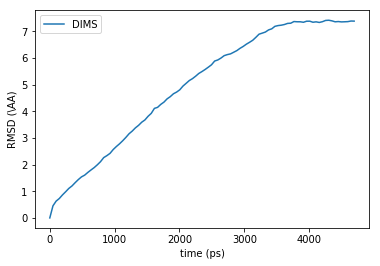

In [104]:
ax1 = plt.subplot(111)
ax1.plot(data[0], data[1], label="DIMS")
ax1.set_xlabel("time (ps)")
ax1.set_ylabel(r"RMSD (\AA)")
ax1.legend(loc="best")

## Writing trajectories
Writing out coordinates (David introduced the selection writer).

### Trajectory Writer
Basic pattern:
1. get a trajectory writer
   - use `with` and context manager
   - provide `n_atoms` (typically from the `AtomGroup` that you are going to write)
   - can use `format` keyword argument if extension is not recognized
2. iterate through a trajectory
3. `write()` each time step (or `AtomGroup`)
4. (close trajectory --- done by context manager)

Converting trajectory formats:

In [81]:
xtc = "new.xtc"
with mda.Writer(xtc, n_atoms=u.atoms.n_atoms) as W:
    for ts in u.trajectory:
        W.write(ts)

In [83]:
!ls -l *.xtc 

-rw-r--r-- 1 oliver oliver 1296904 Oct 13 15:01 new.xtc


In [84]:
uxtc = mda.Universe(psf, xtc)
uxtc

<Universe with 3341 atoms and 3365 bonds>

In [85]:
import os
os.unlink(xtc)

# MDSynthesis appetizer 

Working with many trajectories is tedious....